In [1]:
from torchvision import transforms
from pathlib import Path
import torch

In [2]:
device = "cuda" if torch.cuda.is_available() else "cpu"
print("Using device:", device)

Using device: cuda


In [3]:
data_transform = transforms.Compose([
  transforms.Resize((64, 64)),
  transforms.ToTensor()
])

In [4]:
HIDDEN_UNITS = 64
BATCH_SIZE = 32

In [5]:
from utils import dataloader
base_dir = Path("data/")
train_path = base_dir / 'dataset_1' / 'train'
test_path = base_dir / 'dataset_1'/ 'test'

train_dataloader, test_dataloader, class_names = dataloader.create_dataloaders(
    test_dir=test_path,
    train_dir=train_path,
    transform=data_transform,
    batch_size=BATCH_SIZE,
)

In [6]:
from models import model_builder
model = model_builder.TinyVGG(
    input_shape=3,
    hidden_units=HIDDEN_UNITS,
    output_shape=len(class_names)
).to(device)

In [7]:
from utils.save_load import load_model 
loaded_model = load_model(model=model,
                            target_dir="models",
                            model_name="tiny_vgg_model_1.pth")

[INFO] Loading model from: models\tiny_vgg_model_1.pth


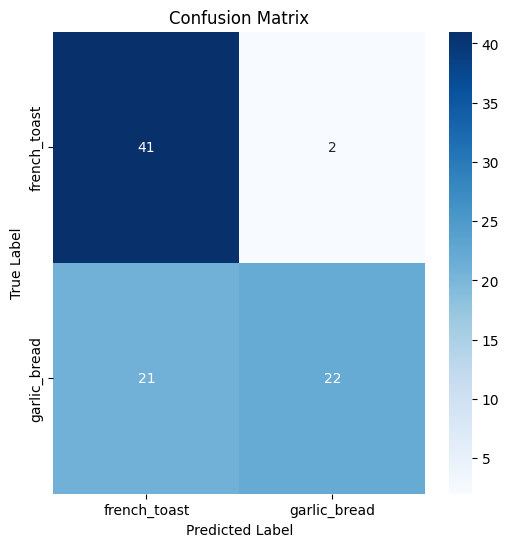

In [8]:
from utils.plots import evaluate_model
evaluate_model(model, test_dataloader, class_names, device)

In [9]:
import random

class_folders = [folder for folder in (base_dir / 'dataset_1' / 'train').iterdir() if folder.is_dir()]
val_random_dir = random.choice(class_folders)
img_files = list(val_random_dir.glob("*.jpg"))
img_path = random.choice(img_files)
print(img_path)

data\dataset_1\train\garlic_bread\garlic_bread_16587.jpg


In [10]:
from utils import heatmap

In [11]:
image_tensor = heatmap.load_image(img_path)

In [16]:
model.eval()
with torch.no_grad():
    preds = model(image_tensor.to(device))

In [13]:
class_index = heatmap.get_class_label(preds)

In [14]:
heatmap_result = heatmap.compute_heatmap(
    model=model,
    image_tensor=image_tensor.to(device),
    class_index=class_index,
    conv_layer_name="conv_block_1"
)

if heatmap_result is None:
    print("Error: compute_heatmap returned None. Please check your input parameters and implementation.")
else:
    print("Heatmap computed successfully.")


Heatmap computed successfully.


c:\Users\gabry\AppData\Local\Programs\Python\Python313\Lib\site-packages\torch\nn\modules\module.py:1830: FutureWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  self._maybe_warn_non_full_backward_hook(args, result, grad_fn)


In [15]:
import cv2

output_image = heatmap.overlay_heatmap(
    image_path=img_path,
    heatmap=heatmap_result,
    alpha=0.5,
)
cv2.imwrite("heatmap_output.jpg", output_image)

True

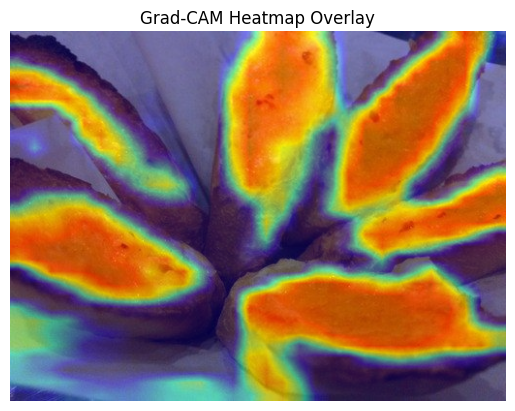

In [ ]:
import matplotlib.pyplot as plt

output_image_rgb = cv2.cvtColor(output_image, cv2.COLOR_BGR2RGB)

# Wyświetlenie
plt.imshow(output_image_rgb)
plt.axis('off')
plt.title("Grad-CAM Heatmap Overlay")
plt.show()